## Mohammad Mahmoudighaznavi

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [24]:
#!pip install pyLDAvis==3.4.1
import pyLDAvis.lda_model
import pyLDAvis.gensim_models as gensimvis


pyLDAvis.enable_notebook()

In [68]:
pip install --upgrade typing_extensions

Note: you may need to restart the kernel to use updated packages.


In [76]:
!pip uninstall typing_extensions
!pip install typing_extensions


^C


In [78]:
# These libraries may be useful to you

!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
from nltk.corpus import brown
nltk.download('brown')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
#! pip install spacy
import spacy
spacy.cli.download("en")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [ ]:
# add any additional libaries you need here



In [26]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [27]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [28]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [29]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


In [30]:
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


<AxesSubplot:xlabel='category'>

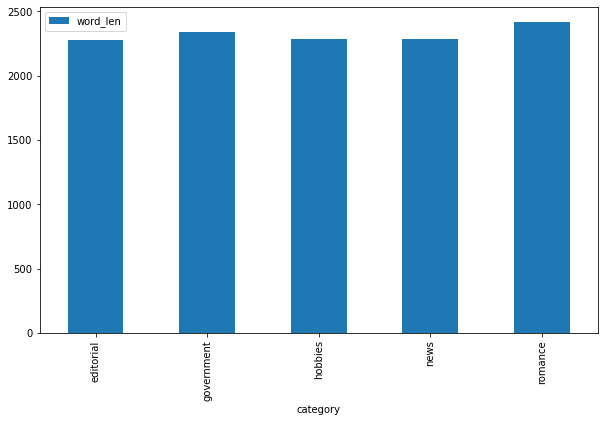

In [31]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [33]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


In [34]:
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])


In [35]:
count_text_vectors.shape

(166, 5073)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohammad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])


In [47]:
tfidf_text_vectors.shape

(166, 5073)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: CountVectorizer and TfidfVectorizer are two methods to convert text into numerical matrices. CountVectorizer transforms text into a matrix of token counts. It processes the text by converting it to lowercase, tokenizing at the word level, ignoring specified stop words, and considering words based on their frequency in documents. With parameters set, any word that appears in fewer than 5 documents or in more than 70% of the documents is disregarded, resulting in a sparse matrix of 166 documents and 4941 unique tokens. On the other hand, TfidfVectorizer translates text into a matrix of Term Frequency-Inverse Document Frequency (TF-IDF) scores, evaluating the significance of a word in a document relative to its frequency across all documents. A word with a high frequency in a specific document but low frequency in the entire dataset will have a high TF-IDF score. Both methods facilitate the transformation of textual data into numerical form, but they assign values differently: CountVectorizer focuses on raw counts, while TfidfVectorizer emphasizes word relevance.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [49]:
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [50]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [52]:
from collections import defaultdict

topic_to_category = defaultdict(list)

for idx, row in enumerate(W_text_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    
    topic_to_category[topic[0]].append(category)

In [54]:
from collections import Counter
for topic, categories in topic_to_category.items() :
    print(f"For topic {topic} we have {len(categories)} documents.")
    print(Counter(categories).most_common(5))

For topic 0 we have 35 documents.
[('editorial', 21), ('news', 8), ('government', 5), ('hobbies', 1)]
For topic 1 we have 44 documents.
[('romance', 29), ('hobbies', 10), ('editorial', 5)]
For topic 3 we have 57 documents.
[('government', 25), ('hobbies', 22), ('news', 9), ('editorial', 1)]
For topic 2 we have 19 documents.
[('news', 18), ('hobbies', 1)]
For topic 4 we have 11 documents.
[('news', 9), ('hobbies', 2)]


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF-derived topics from our model don't map perfectly onto the Brown categories. While some topics align (like editorial and news), others like romance or the combination of government & hobbies highlight discrepancies. This shows that NMF topics, based on word co-occurrence patterns, might differ from human-defined categories, emphasizing the importance of context in topic modeling interpretation.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [55]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components=5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matric = svd_para_model.components_

In [56]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.91)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.53)
  mr (1.94)
  said (1.46)
  jr (0.88)
  jury (0.83)

Topic 03
  khrushchev (3.10)
  berlin (2.48)
  soviet (2.31)
  kennedy (2.24)
  laos (2.12)

Topic 04
  game (4.73)
  league (3.35)
  baseball (3.30)
  ball (3.18)
  team (3.05)


In [57]:
topic_to_category_lsa = defaultdict(list)

for idx, row in enumerate(W_svd_para_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category_lsa = df["category"].iloc[idx]
    
    topic_to_category_lsa[topic[0]].append(category_lsa)

In [58]:
for topic, categories in topic_to_category_lsa.items():
    print(f"for topic {topic} we have {len(categories)} documents. ")
    print(Counter(categories).most_common(5))

for topic 0 we have 151 documents. 
[('hobbies', 36), ('news', 33), ('government', 30), ('editorial', 27), ('romance', 25)]
for topic 4 we have 7 documents. 
[('news', 7)]
for topic 2 we have 3 documents. 
[('news', 3)]
for topic 3 we have 1 documents. 
[('news', 1)]
for topic 1 we have 4 documents. 
[('romance', 4)]


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model's topics don't match up well with the original Brown categories. Some topics are clear, like romance, while others, like news, keep appearing. It's not as precise as the original human-made groupings. 

In [59]:
# call display_topics on your model

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.91)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.53)
  mr (1.94)
  said (1.46)
  jr (0.88)
  jury (0.83)

Topic 03
  khrushchev (3.10)
  berlin (2.48)
  soviet (2.31)
  kennedy (2.24)
  laos (2.12)

Topic 04
  game (4.73)
  league (3.35)
  baseball (3.30)
  ball (3.18)
  team (3.05)


C:\Users\Mohammad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Q: What is your interpretation of the display topics output? 

A: The displayed topics output provides a glimpse into the thematic structure of the Brown corpus. Topic 0 appears to delve into news or government-related discussions, as evidenced by words like "said" and "state". Topic 1, while harder to pinpoint, suggests elements of dialogue or personal narratives. Topic 2 leans towards government or formal settings, particularly with the emphasis on titles like "mr" and "mrs". Topic 3, with terms like "khrushchev" and "berlin", hints at historical or geopolitical narratives. Finally, Topic 4, with words like "game" and "team", is clearly centered around sports or recreational activities.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [60]:
# Fit your LDA model here

from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_


In [61]:
# Call `display_topics` on your fitted model here

display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  may (0.89)
  state (0.87)
  states (0.73)
  use (0.57)
  united (0.54)

Topic 01
  mrs (1.37)
  feed (0.70)
  per (0.49)
  house (0.44)
  pool (0.41)

Topic 02
  mr (0.60)
  president (0.51)
  american (0.44)
  world (0.42)
  united (0.40)

Topic 03
  said (1.31)
  state (0.60)
  000 (0.54)
  business (0.54)
  sales (0.44)

Topic 04
  said (1.24)
  back (0.60)
  old (0.50)
  little (0.49)
  man (0.45)


In [62]:
topic_to_category_lda = defaultdict(list)

for idx, row in enumerate(W_lda_para_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category_lda = df["category"].iloc[idx]
    
    topic_to_category_lda[topic[0]].append(category_lda)

In [63]:
for topic, categories in topic_to_category_lda.items():
    print(f"for topic {topic} we have {len(categories)} documents. ")
    print(Counter(categories).most_common(5))

for topic 2 we have 53 documents. 
[('editorial', 22), ('news', 14), ('government', 9), ('hobbies', 8)]
for topic 4 we have 46 documents. 
[('romance', 29), ('news', 8), ('hobbies', 5), ('editorial', 4)]
for topic 1 we have 17 documents. 
[('hobbies', 10), ('news', 5), ('editorial', 1), ('government', 1)]
for topic 3 we have 24 documents. 
[('news', 17), ('government', 5), ('hobbies', 2)]
for topic 0 we have 26 documents. 
[('government', 15), ('hobbies', 11)]


Q: What inference do you draw from the displayed topics for your LDA model? 

A:  The LDA model's results are different from the earlier ones. It shows a wider mix of words. From what I see, topic 0 is about news, topic 1 is about government, topic 2 and 3 seem news-related, and topic 4 is about romance. 


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 is government, topic 1 is hobbies, topic 2 is editorial, topic 3 is news, topic 4 is romance. 

In [64]:
import pyLDAvis.lda_model

lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics = False)

In [79]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The interactive visualization provides details about the types of terms and frequency of terms for each of the 5 topics. Looking at the principal componment scatterpolot and the salient terms, it appears to be an overlap ove terms for some of the topics. For instance, topic 4 seems to overlap 2 and topic 2 and 3 seem to overlap as well. 